In [1]:
import numpy as np
import torch
import torch.nn as nn
from models import *
import torchvision
from torchvision import transforms, datasets
from torch.distributions import normal
import matplotlib.pyplot as plt
import captum
from captum.attr import DeepLift, IntegratedGradients, Saliency, NoiseTunnel, GradientShap
from captum.attr import visualization as viz
import argparse
from utils import get_args
import matplotlib
from models.model import *
from models.capsule import *

/home/bhui/miniconda3/envs/xy_py38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def add_gaussian_noise(noise_scale, input):
    noise = torch.randn_like(input) * noise_scale
    return input + noise

def predict_with_randomized_smoothing(noise_scale, model, image, num_samples):
    # Expand the single image to a batch
    image_batch = image.repeat(num_samples, 1, 1, 1)
    # Add Gaussian noise
    noisy_images = add_gaussian_noise(noise_scale, image_batch)

    # Predict using the model
    predictions, reconstruction ,primary_caps_output, digit_caps_output, c, b = model(noisy_images)

    # Get the predicted classes for each noisy image
    _, predicted_classes = predictions.max(1)
    #Result
    avg_noisy_image = noisy_images.mean(0, keepdim=True)
    prediction = torch.bincount(predicted_classes).argmax().item()
    # Return the most frequently predicted class
    return avg_noisy_image, predictions, predicted_classes, prediction

def show_image(input, noise_scale):
    fig, axes = plt.subplots(1, len(noise_scale), figsize=(20, 10))
    if not isinstance(axes, (list, np.ndarray)):
        axes = [axes]
    for idx, noise in enumerate(noise_scale):
        avg_noisy_image, predictions, predicted_classes, prediction= predict_with_randomized_smoothing(noise, global_model, input, 100)
        print(f'Noise: {noise}, Ground Truth: {ground_truth_prediction}, Noised Result: {prediction}')
        img = avg_noisy_image.squeeze().cpu().detach().numpy()
        img = (img - img.min()) / (img.max() - img.min())
        ax = axes[idx]
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        ax.set_title(f'noise_scale:{noise}')
    plt.tight_layout()
    plt.show()

Noise: 0, Ground Truth: 7, Noised Result: 7
Noise: 0.5, Ground Truth: 7, Noised Result: 7
Noise: 1, Ground Truth: 7, Noised Result: 7
Noise: 1.5, Ground Truth: 7, Noised Result: 8
Noise: 2.0, Ground Truth: 7, Noised Result: 8
Noise: 2.5, Ground Truth: 7, Noised Result: 8
Noise: 3.0, Ground Truth: 7, Noised Result: 8
Noise: 3.5, Ground Truth: 7, Noised Result: 8
Noise: 4.0, Ground Truth: 7, Noised Result: 8
Noise: 4.5, Ground Truth: 7, Noised Result: 8
Noise: 5.0, Ground Truth: 7, Noised Result: 8


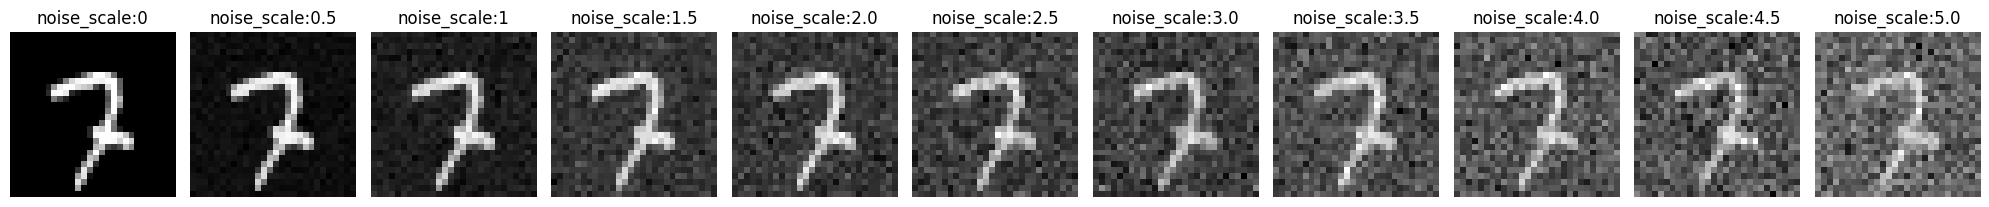

In [10]:
args = get_args.get_arg()
data_dir = './data/mnist'
sigma = 0.5
apply_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(data_dir, train=True, download=True, transform=apply_transform)
test_dataset = datasets.MNIST(data_dir, train=False, download=True, transform=apply_transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128,
                                          shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128,
                                         shuffle=False, num_workers=2)
device = 'cuda'
global_model = CapsNet(device=device)
global_model.load_state_dict(torch.load(f'./checkpoints/Capsule/mnist/common/checkpoint_mnist_epoch30.pth'))
# global_model.load_state_dict(torch.load(f'./checkpoints/Capsule/mnist/common/best_model_mnist.pth'))
global_model.to(device)
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
ind = 41
input = images[ind].unsqueeze(0)
input.requires_grad = True
global_model.eval()
ground_truth_predictions, reconstruction, primary_caps_output, digit_caps_output, c, b= global_model(input)
_, predicted_classes = ground_truth_predictions.max(1)
ground_truth_prediction = torch.bincount(predicted_classes).argmax().item()
noise_scale = [0, 0.5, 1, 1.5, 2.0, 2.5, 3.0 ,3.5, 4.0, 4.5, 5.0]
show_image(input, noise_scale)

In [11]:
label_list = list()
for i, label in enumerate(labels):
    label_list.append(f'{i}: {classes[label]}')

In [12]:
def forward_logits_only(input_data):
    return global_model(input_data)[0]

In [13]:
saliency = Saliency(forward_logits_only)
ig = IntegratedGradients(forward_logits_only)
dl = DeepLift(forward_logits_only)
nt = NoiseTunnel(ig)
print('-------------------')
print('Original Image')
print('Predicted:', classes[predicted_classes],
      ' Probability:', torch.max(F.softmax(ground_truth_predictions, 1)).item())


-------------------
Original Image
Predicted: 7  Probability: 0.20104677975177765


In [14]:
def visualization(noise_scale, model, input):
    avg_noisy_image, predictions, predicted_classes, prediction= predict_with_randomized_smoothing(noise_scale, model, input, 100)
    global_model.zero_grad()
    tensor_attributions = ig.attribute(input, 
                                   target=labels[ind], 
                                   baselines=avg_noisy_image * 0, 
                                   n_steps=1000, 
                                   return_convergence_delta=True)
    attr_ig, delta = tensor_attributions
    tensor_28x28 = attr_ig.squeeze().cpu().detach().reshape(28, 28)
    attr_ig = np.transpose(tensor_28x28.detach().numpy(), (1, 0))
    print('-------------------')
    print('Smoothing Image')
    print('Predicted:', classes[prediction], ' Probability:', torch.max(F.softmax(predictions, 1)).item())
    attr_ig = attr_ig[:, :, np.newaxis]
    avg_noisy_np = avg_noisy_image.squeeze().unsqueeze(-1).cpu().detach().numpy()
    _, axis = viz.visualize_image_attr(attr_ig, avg_noisy_np, method="masked_image", sign="positive",
                              show_colorbar=True, title="Overlayed Integrated Gradients", use_pyplot=True)

-------------------
Smoothing Image
Predicted: 7  Probability: 0.201076477766037


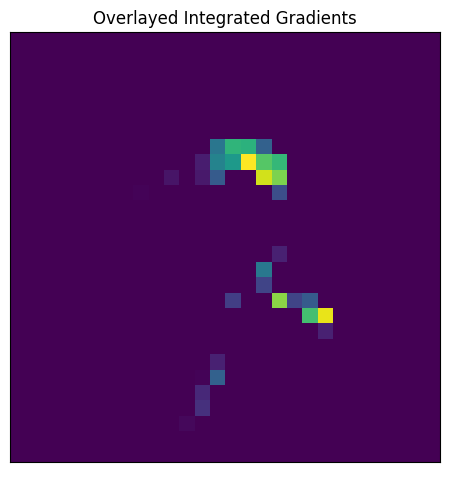

In [15]:
visualization(noise_scale=0.001, model=global_model, input=input)

In [ ]:
def test_capsule(model, device, test_loader):
    model.eval()
    correct, total = 0, 0
    for images, labels in test_loader:
        # Add channels = 1
        images = images.to(device)
        # Categogrical encoding
        labels = torch.eye(10).index_select(dim=0, index=labels).to(device)
        logits, reconstructions, primary_caps_output, digit_caps_output, c, b = model(images)
        pred_labels = torch.argmax(logits, dim=1)
        correct += torch.sum(pred_labels == torch.argmax(labels, dim=1)).item()
        total += len(labels)

    print('Accuracy: {}'.format(correct / total))
test_capsule(global_model, device, test_loader)
test_capsule(global_model, device, train_loader)

In [46]:
def visual_images(model, index):
    input = images[index].unsqueeze(0)
    label = labels[index]
    input.requires_grad = True
    global_model.eval()
    ground_truth_predictions, reconstruction, primary_caps_output, digit_caps_output, c, b = global_model(input)
    reconstruction_min = reconstruction.min()
    reconstruction_max = reconstruction.max()
    normalized_reconstruction = (reconstruction - reconstruction_min) / (reconstruction_max - reconstruction_min)
    _, predicted_class_index = torch.max(ground_truth_predictions, 1)
    is_correct = (predicted_class_index == labels[index]).item()
    original_image = images[index].view(28, 28).cpu().detach().numpy()
    reconstructed_image = reconstruction.view(28, 28).cpu().detach().numpy()
    normalized_reconstruction_image = normalized_reconstruction.view(28, 28).cpu().detach().numpy()
    actual_class = classes[labels[index].item()]
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))
    axes[0].imshow(original_image, cmap='gray')
    axes[0].set_title("Original Image - " + actual_class)
    axes[0].axis('off')  
    axes[1].imshow(reconstructed_image, cmap='gray')
    axes[1].set_title("Reconstructed Image" + (" - Correct" if is_correct else " - Incorrect"))
    axes[1].axis('off')  
    axes[2].imshow(normalized_reconstruction_image, cmap='gray')
    axes[2].set_title("Normalized Reconstructed Image" )
    axes[2].axis('off')  
    return reconstruction

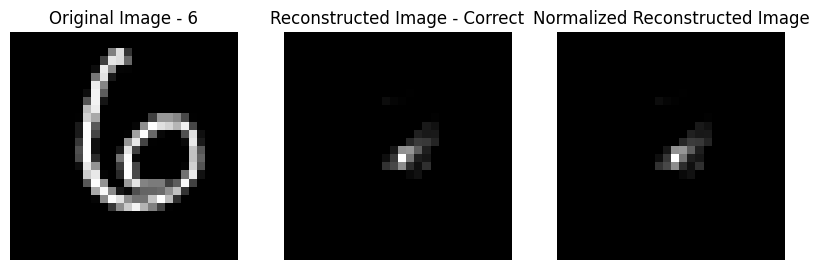

In [47]:
reconstruction1 = visual_images(global_model, 100)

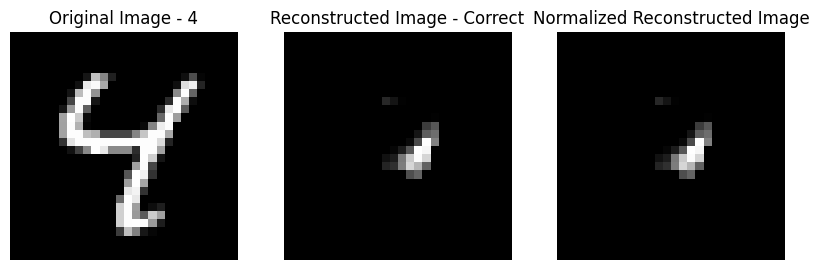

In [48]:
reconstruction2 = visual_images(global_model, 6)

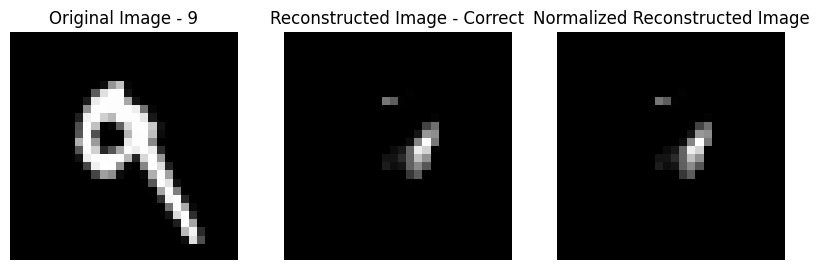

In [49]:
reconstruction3 = visual_images(global_model, 7)

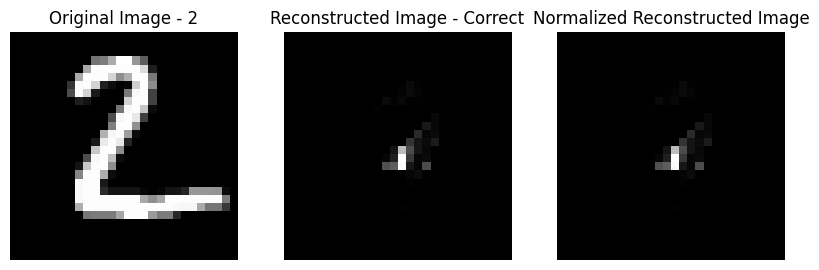

In [50]:
reconstruction4 = visual_images(global_model, 1)

In [51]:
def visual_images2(model, index):
    input = images[index].unsqueeze(0)
    label = labels[index]
    input.requires_grad = True
    model.eval()
    ground_truth_predictions, reconstruction , primary_caps_output, digit_caps_output ,c , b= model(input)
    _, predicted_class_index = torch.max(ground_truth_predictions, 1)
    print('--------------------')
    print(f'The size of primary caps is {primary_caps_output.size()}')
    print(f'The size of digit caps is {digit_caps_output.size()}')
    print('--------------------')
    print('Primary Caps: ', primary_caps_output)
    print('Digit Caps: ', digit_caps_output)
    print('--------------------')
    print(f'The size of c is {c.size()}')
    print(f'The size of b is {b.size()}')
    print('c: ', c)
    print('b: ', b)
    return primary_caps_output, digit_caps_output, c, b, reconstruction

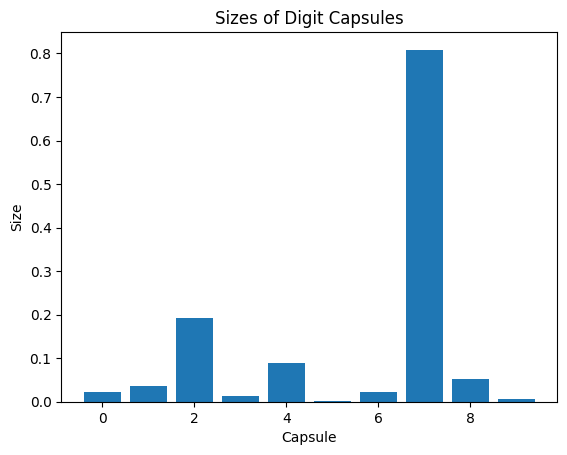

In [52]:
def visualize_digit_caps_output(digit_caps_output):
    caps_sizes = np.linalg.norm(digit_caps_output.squeeze().cpu().detach().numpy(), axis=1)
    plt.bar(range(len(caps_sizes)), caps_sizes)
    plt.xlabel('Capsule')
    plt.ylabel('Size')
    plt.title('Sizes of Digit Capsules')
    plt.show()
visualize_digit_caps_output(digit_caps_output)

tensor([], device='cuda:0', dtype=torch.int64)


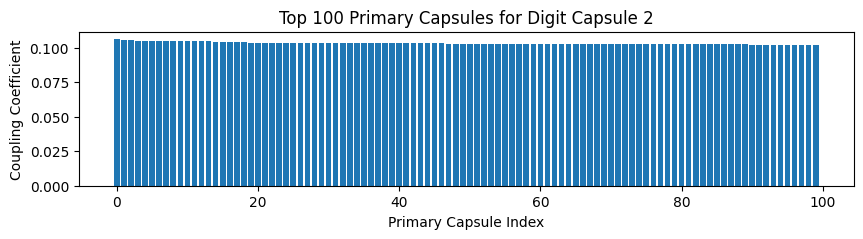

In [53]:
def visualize_top_n_primary_caps_for_digit_caps(c, digit_caps_index, top_n):
    threshold = 0.2
    coupling_coeffs = c[0, digit_caps_index].squeeze()
    indices = torch.where(coupling_coeffs > threshold)[0]
    print(indices)
    top_n_indices = coupling_coeffs.topk(top_n).indices
    plt.figure(figsize=(10, 2))
    plt.bar(range(top_n), coupling_coeffs[top_n_indices].cpu().detach().numpy())
    plt.xlabel('Primary Capsule Index')
    plt.ylabel('Coupling Coefficient')
    plt.title(f'Top {top_n} Primary Capsules for Digit Capsule {digit_caps_index}')
    plt.show()
visualize_top_n_primary_caps_for_digit_caps(c, 2, top_n=100)

In [54]:
primary_caps_output.shape

torch.Size([1, 1152, 8])

In [55]:
#-----Select-----
def modify_primary_caps_output(primary_caps_output, indices):
    modified_output = torch.zeros_like(primary_caps_output)
    for index in indices:
        modified_output[:, index, :] = primary_caps_output[:, index, :]
    return modified_output
#-----Reconstruction-----
def reconstruct_image_with_selected_capsules(model, primary_caps_output, indices):
    modified_primary_caps_output= modify_primary_caps_output(primary_caps_output, indices)
    digit_caps_output, c, b = model.digit_caps(modified_primary_caps_output)
    logits = torch.norm(digit_caps_output, dim=-1)
    pred = torch.eye(10).to(model.device).index_select(dim=0, index=torch.argmax(logits, dim=1))
    batch_size = digit_caps_output.shape[0]
    reconstruction = model.decoder((digit_caps_output * pred.unsqueeze(2)).contiguous().view(batch_size, -1))
    image_size=(28, 28)
    image = reconstruction.view(*image_size).cpu().detach().numpy()
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.title(f'Capsule {indices}')
    plt.show()
    return reconstruction

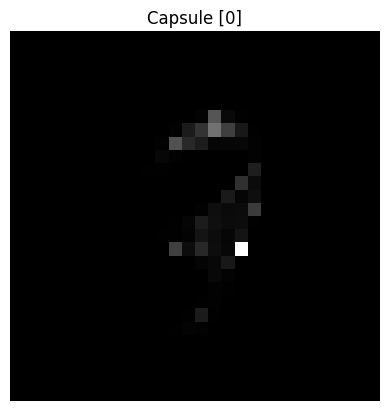

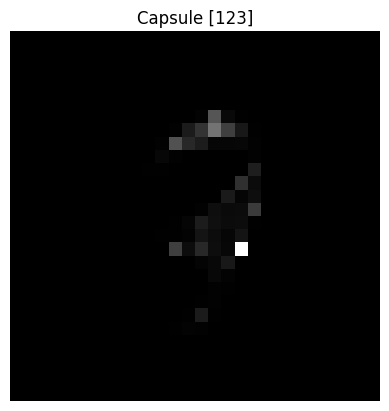

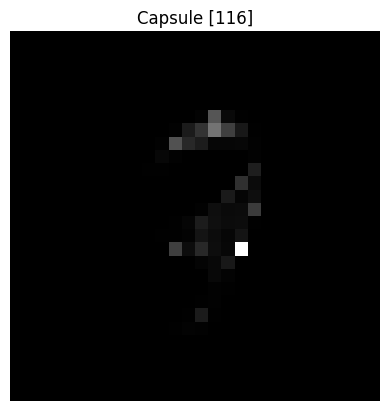

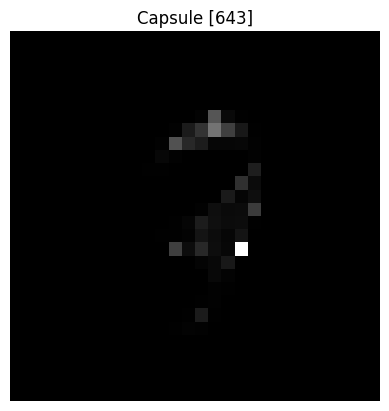

In [59]:
reconstruction_new = reconstruct_image_with_selected_capsules(global_model, primary_caps_output, [0])
reconstruction_new = reconstruct_image_with_selected_capsules(global_model, primary_caps_output, [123])
reconstruction_new = reconstruct_image_with_selected_capsules(global_model, primary_caps_output, [116])
reconstruction_new = reconstruct_image_with_selected_capsules(global_model, primary_caps_output, [643])

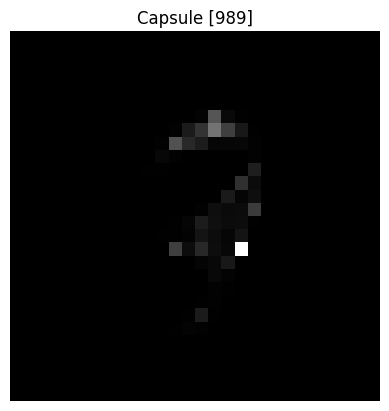

In [57]:
reconstruction_new = reconstruct_image_with_selected_capsules(global_model, primary_caps_output, [989])